##  Preprocessing, and Modeling<a id='1_Modeling'></a>

## 1.1 Contents<a id='1.1_Contents'></a>

* [1  Preprocessing, and Modeling](#1_Modeling)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Objective](#1.2_Objectives)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Loading Data](#1.6_Bird_Data)
  * [1.5 Transfer Learning](#1.5_TL)
    * [1.5.1 EfficientNet](#1.6.1_EF)
    * [1.5.2 VGG16](#1.5.2_VG)
    * [1.5.3  VGG16 Tuning](#1.5.3_VG_T)
  * [1.6 Predictions](#1.6_Predictions)
  * [1.7 Summary](#1.Summary)

## 1.2 Objective<a id='1.2_Objectives'></a>

In this notebook my goal is to take learn from my previous model build in Notebook 1, and utilize transfer learning to build a more robust and predictive model. I will be utilizing different pre-existing trained neural networks and fine-tuning those networks to cater towards my birds dataset. 

## 1.3 Imports<a id='1.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from os import listdir
from os.path import isfile, join
from PIL import Image
import bpy
import random
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from tensorflow.keras.models import load_model, Model
from skimage import color
import keras

## 1.4 Loading Data<a id='1.4_Bird_Data'></a>

ImageDataGenerator is a useful class which allows for various manipulation and control of our dataset such as generating batches of tensor image data. Our method in use is flow_from_directory which allows for images to be processed into batches with our desired pixel size. There are other things that can be done such as data augmentation and etc but in our case we only needed to utilize preprocess_input which 

In [105]:
datagen_ = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                 zoom_range=(0.8, 1.2)) 
# We set shuffle to False so we can compare predicted labels to true labels
train_generator = datagen_.flow_from_directory('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/train',
                                                      batch_size=64,
                                                      target_size=(224,224),
                                                      shuffle = True,
                                                      class_mode='categorical')
test_generator = datagen_.flow_from_directory('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/test',
                                                           batch_size=64,
                                                           target_size=(224,224),
                                                           shuffle = True,
                                                           class_mode='categorical')
#
valid_generator = datagen_.flow_from_directory('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/birds/valid',
                                                           batch_size=64,
                                                           target_size=(224,224),
                                                           shuffle = True,
                                                           class_mode='categorical')

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


## 1.5 Transfer Learning<a id='1.5_TL'></a>

Transfer learning is the idea which a model is developed to learn and identify a certain task and it can be resused for similar task and tuned to refinement. The difficulty with Neural Network models are they are computation expensive, take long time, and take large dataset I am talking about over millions of data to train a fully fledged neural network but companies such as Google create large such robust models such as ResNet, mobilenet, EfficientNet and etc. We can utilize these pre-build/trained models and fine tune to our own models. The analogy that is widely used is imagine your ancestors once they learned something like skills and language and other tools that help humanity learn and survive, they have this vast knowledge since they lived their life but once their offspring are born, the babies are blank slate they know nothing but the parents pass over that knowledge so the babies don't have to start from ground zero, they utilize their parents knowledge and adapt to their environment. Such is the case of transfer learning. 

Transfer learning is using past predecessor's knowledge to increase the learning capabilities of new models. 
Pre-Trained models are models created by someone or others to solve a similar problem but rather than building a model from scratch you utilize and tweak their already built model to your own problem.  

Two of the most popular neural networks are EfficientNet and VGG16 and in this notebook I will be utilizing their networks to incorporate and tune to my dataset. EfficientNet is a CNN architecture where the scaling method uniformly scales the dimensions of depth, width and resolution using a compound coefficient. Traditional practice scales these factors arbitrary but EfficientNet utilizes this uniform scaling method to set a fixed scaling coefficients. For instances  if we needed $2^N$ more computational power, we can just increase the network depth by $\alpha^N$, width by $\beta^N$, and image size by $\gamma^N$ where $\alpha, \beta, \gamma$ are coefficients which are constanted and determined by a grid search on the original small model. 



### 1.5.1 EfficientNet <a id='1.6.1_EF'></a>

#### Sidenote, I was able to achieve a 94% accuracy rate with my model, when I trained 100 epochs, but along the way I wanted to do some theory crafting and messed around with the model without saving it, now I am not willing to re-spent that time training the model all over again since I have already got 97+% from a VGG model but it is unfortunately I attempted to recreate it but to no avail the results do not compare to previous work. 

I download and import EfficientNetB0 and in doing so I only want to take its pre-trained weights and its layers not the output but luckily EfficientNetB0 is setup where we can configure the input shape and which weights we want, without having to do much configuring and we will see this is a issue we will have to resolve with vgg_16 below but thats later. 

After loading up efficientnetb0 I add to a sequential model as initially it is a functional API. I allow the dropout rate to be 0.2 as this typical as resulted in the best result in my testing in the past. I also add our output layer of 315 classes of bird species but recall this is one-hot encoded into binary 0, 1 coding. 

In [106]:
model_EF = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_EF.trainable = False


model = Sequential([model_EF, Flatten(), 
                       Dropout(rate=0.2), layers.BatchNormalization(), 
                       Dense(315, activation='softmax')])

model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics="accuracy")

In [107]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_4 (Dropout)         (None, 62720)             0         
                                                                 
 batch_normalization_6 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 315)               19757115  
                                                                 
Total params: 24,057,566
Trainable params: 19,882,555
Non-trainable params: 4,175,011
__________________________________

Again I utilize callback to implement early stopping and reduction of learning rate. 

In [108]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

model_hist = model.fit(ef_train_generator,
                            epochs=40,
                            validation_data=ef_valid_generator,
                            callbacks=callback)

Epoch 1/40
719/719 [==============================] - 367s 504ms/step - loss: 23.8566 - accuracy: 0.0151 - val_loss: 10.2067 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 2/40
719/719 [==============================] - 341s 474ms/step - loss: 19.7348 - accuracy: 0.1360 - val_loss: 9.3719 - val_accuracy: 0.3486 - lr: 0.0010
Epoch 3/40
719/719 [==============================] - 342s 475ms/step - loss: 17.5615 - accuracy: 0.1774 - val_loss: 8.0606 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 4/40
719/719 [==============================] - 340s 473ms/step - loss: 15.8982 - accuracy: 0.2108 - val_loss: 6.9942 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 5/40
719/719 [==============================] - 338s 469ms/step - loss: 14.0843 - accuracy: 0.2252 - val_loss: 6.2196 - val_accuracy: 0.3784 - lr: 0.0010
Epoch 6/40
719/719 [==============================] - 338s 470ms/step - loss: 12.3872 - accuracy: 0.2434 - val_loss: 5.2916 - val_accuracy: 0.3746 - lr: 0.0010
Epoch 7/40
719/719 [===================

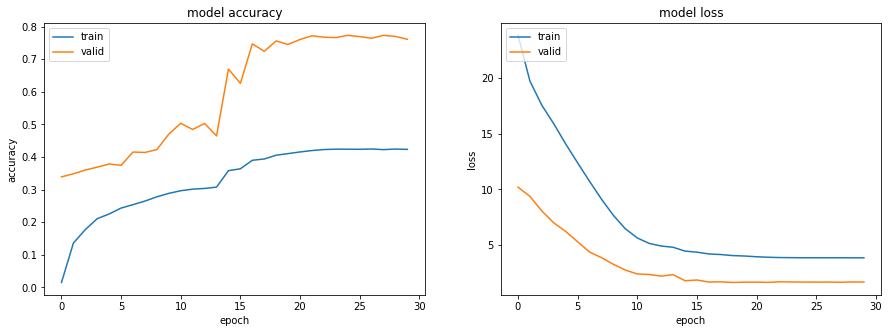

In [109]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model_hist.history['accuracy'])
ax[0].plot(model_hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'], loc='upper left')


ax[1].plot(model_hist.history['loss'])
ax[1].plot(model_hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'], loc='upper left')
plt.show()

In [86]:
model.save('efficientnet0_model')

INFO:tensorflow:Assets written to: efficientnet0_model\assets


C:\Users\izine\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\izine\AppData\Roaming\Python\Python38\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [87]:
ef_model =  keras.models.load_model('efficientnet0_model')

In [88]:
ef_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_3 (Dropout)         (None, 62720)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 315)               19757115  
                                                                 
Total params: 24,057,566
Trainable params: 19,882,555
Non-trainable params: 4,175,011
__________________________________

In [89]:
_, acc = ef_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 14s 516ms/step - loss: 2.9442 - accuracy: 0.4978
Valid Accuracy: 49.778


Unfreezing and freezing of layers are popular methods of tuning pre-trained models as it allows for quick training without losing too much time, in an ideal world you would want all layers to be unfrozen so the model can re-train on your own dataset but this is a time consuming task. 

#### Let's unfreeze some layers to see if it improves performance

In [39]:
model_EF = ef_model.layers[0]

In [40]:
model_EF.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [45]:
model_EF.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [99]:
model_EF.trainable = False

# for l in model_EF.layers:
#     if 'block6' in l.name or 'block7' in l.name or l.name in ['top_conv','top_bn','top_activation','max_pool']:
#         l.trainable = True

In [100]:

for l in model_EF.layers:
    print(l.name, l.trainable)

input_6 False
rescaling_5 False
normalization_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [104]:
callback = [EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

ef_model.compile(optimizer=Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics="accuracy")

model_hist = ef_model.fit(train_generator,
                            epochs=20,
                            validation_data=valid_generator,
                            callbacks=callback)

Epoch 1/20
719/719 [==============================] - 381s 524ms/step - loss: 3.9684 - accuracy: 0.4092 - val_loss: 2.1569 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 2/20
719/719 [==============================] - ETA: 0s - loss: 3.9631 - accuracy: 0.4097
Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
719/719 [==============================] - 375s 522ms/step - loss: 3.9631 - accuracy: 0.4097 - val_loss: 2.1649 - val_accuracy: 0.6921 - lr: 1.0000e-05
Epoch 3/20
719/719 [==============================] - 373s 519ms/step - loss: 3.9541 - accuracy: 0.4096 - val_loss: 2.1490 - val_accuracy: 0.6959 - lr: 5.0000e-06
Epoch 4/20
719/719 [==============================] - 374s 520ms/step - loss: 3.9499 - accuracy: 0.4111 - val_loss: 2.1291 - val_accuracy: 0.7003 - lr: 5.0000e-06


In [102]:
_, acc = ef_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 13s 512ms/step - loss: 2.0338 - accuracy: 0.7010
Valid Accuracy: 70.095


In [96]:
ef_model.save('efficientnet0_model')

INFO:tensorflow:Assets written to: efficientnet0_model\assets


C:\Users\izine\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\izine\AppData\Roaming\Python\Python38\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [28]:
# X_train_file = np.load('X_train_file.npy', allow_pickle=True)
# X_test_file = np.load('X_test_file.npy', allow_pickle=True)
# X_valid_file = np.load('X_valid_file.npy', allow_pickle=True)


# X_train = X_train_file.item()['data']
# y_train = X_train_file.item()['label'] 
# X_test = X_test_file.item()['data']
# y_test = X_test_file.item()['label'] 
# X_valid = X_valid_file.item()['data']
# y_valid = X_valid_file.item()['label'] 

In [3]:
# print('X_train shape:'+str(X_train.shape), 'y_train shape:'+str(y_train.shape))
# print('X_test shape:'+str(X_test.shape), 'y_test shape:'+str(y_test.shape))
# print('X_valid shape:'+str(X_valid.shape), 'y_valid shape:'+str(y_valid.shape))

X_train shape:(45980, 56, 56, 3) y_train shape:(45980, 315)
X_test shape:(1575, 56, 56, 3) y_test shape:(1575, 315)
X_valid shape:(1575, 56, 56, 3) y_valid shape:(1575, 315)


In [4]:
# Curious I wanted to see how my model would do with higher pixel count

This was our best model in the previous notebook, Here we will test it one more time but using valid dataset to evaluate.

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(56, 56, 3), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(315, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics="accuracy")



# model_hist = model.fit(X_train, y_train,  callbacks=callback, epochs=100, validation_data=(X_test, y_test))

# _, acc = model.evaluate(X_valid, y_valid, verbose=1)
# print('Valid Accuracy: %.3f' % (acc * 100))

## 1.5.2 VGG16 <a id='1.5.2_VG'></a>

#### Vgg 16 was invented by the Visual Gemoetry Group of Oxford University and proposed by Karen Simonyan and Andrew Zisserman, it was used to win 1st place at 2014 ILSVRC callenge. A key distinction with VGG16 is rather than have large number of hyper-parameters they instead focused on having many convolution layers of 3v3 filters and alway used same padding with a maxpool layer of 2x2. The 16 in its name represents the 16 layers which have weights, the network itself has approximately 138 million parameters. 

In [38]:
vgg_model = keras.applications.vgg16.VGG16(input_shape=(224,224,3))

In [39]:
vgg_model.trainable = False

In [40]:
vgg_model.summary() 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Do an initial check on if all the layers are frozen. 

In [41]:
for l in vgg_model.layers:
    print(l.name, l.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False
predictions False


In [42]:
vg_model = Sequential()
for layer in vgg_model.layers:
    vg_model.add(layer)

In [43]:
vg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

I am removing the last layer which is an output layer since our classification problem requires identifying 315 bird species we must reconfigure to our needs.

In [44]:
vg_model.pop()

In [45]:
vg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
Adding of the last layer to our classification problem of 315 different classes of birds.

In [46]:
vg_model.add(Dense(315,activation='softmax'))

In [47]:
vg_model.compile(
            Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [49]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

vg_model_hist = vg_model.fit(train_generator,
                            epochs=40,
                            validation_data=valid_generator,
                            callbacks=callback, verbose=1)

Epoch 1/40
719/719 [==============================] - 417s 579ms/step - loss: 6.3980 - accuracy: 0.0906 - val_loss: 2.5667 - val_accuracy: 0.3937 - lr: 1.0000e-04
Epoch 2/40
719/719 [==============================] - 408s 568ms/step - loss: 2.2603 - accuracy: 0.4233 - val_loss: 1.3804 - val_accuracy: 0.6324 - lr: 1.0000e-04
Epoch 3/40
719/719 [==============================] - 406s 565ms/step - loss: 1.4524 - accuracy: 0.6045 - val_loss: 0.9416 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 4/40
719/719 [==============================] - 401s 558ms/step - loss: 1.0648 - accuracy: 0.7068 - val_loss: 0.7197 - val_accuracy: 0.8044 - lr: 1.0000e-04
Epoch 5/40
719/719 [==============================] - 404s 561ms/step - loss: 0.8829 - accuracy: 0.7512 - val_loss: 0.6057 - val_accuracy: 0.8356 - lr: 1.0000e-04
Epoch 6/40
719/719 [==============================] - 400s 556ms/step - loss: 0.7240 - accuracy: 0.7950 - val_loss: 0.5368 - val_accuracy: 0.8368 - lr: 1.0000e-04
Epoch 7/40
719/719 [==

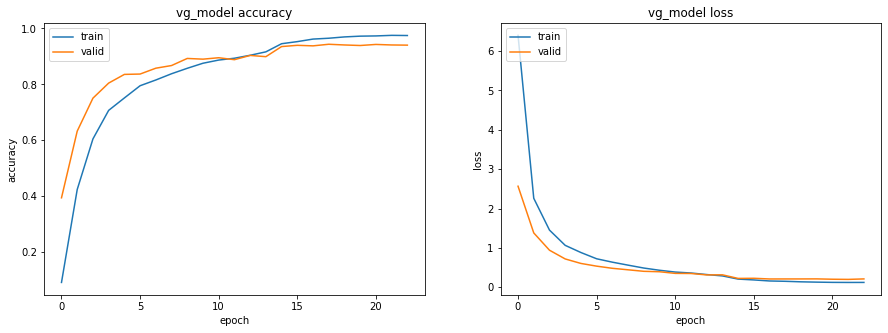

In [50]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(vg_model_hist.history['accuracy'])
ax[0].plot(vg_model_hist.history['val_accuracy'])
ax[0].set_title('vg_model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'], loc='upper left')


ax[1].plot(vg_model_hist.history['loss'])
ax[1].plot(vg_model_hist.history['val_loss'])
ax[1].set_title('vg_model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'], loc='upper left')
plt.show()

In [51]:
_, acc = vg_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 12s 472ms/step - loss: 0.1930 - accuracy: 0.9498
Valid Accuracy: 94.984


In [52]:
vg_model.save('vg_model')

INFO:tensorflow:Assets written to: vg_model\assets


### 1.5.3 VGG16 Tuning <a id='1.5.3_VG_T'></a>

In [4]:
vg_model = keras.models.load_model('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/Notebooks/vg_model')

In [73]:
for l in vg_model.layers:
    print(l.name, l.trainable)

block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False
dense_1 True


#### Here we allow all layers after the last two convolution blocks to be unfrozen. 

In [74]:
vg_model.trainable = True

set_trainable = False
for layer in vg_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        


In [75]:
for l in vg_model.layers:
    print(l.name, l.trainable)

block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
dense_1 True


Since we have already trained our model we can utilize a lower learning rate 

In [77]:
vg_model.compile(Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [78]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

vg_model_hist = vg_model.fit(train_generator,
                            epochs=20,
                            validation_data=valid_generator,
                            callbacks=callback, verbose=1)

Epoch 1/20
719/719 [==============================] - 353s 487ms/step - loss: 0.5211 - accuracy: 0.8499 - val_loss: 0.3741 - val_accuracy: 0.8984 - lr: 1.0000e-05
Epoch 2/20
719/719 [==============================] - 340s 473ms/step - loss: 0.2606 - accuracy: 0.9259 - val_loss: 0.3064 - val_accuracy: 0.9187 - lr: 1.0000e-05
Epoch 3/20
719/719 [==============================] - 338s 469ms/step - loss: 0.2485 - accuracy: 0.9376 - val_loss: 0.2481 - val_accuracy: 0.9422 - lr: 1.0000e-05
Epoch 4/20
719/719 [==============================] - 330s 458ms/step - loss: 0.1130 - accuracy: 0.9729 - val_loss: 0.1347 - val_accuracy: 0.9663 - lr: 1.0000e-05
Epoch 5/20
719/719 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9848
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
719/719 [==============================] - 336s 468ms/step - loss: 0.0661 - accuracy: 0.9848 - val_loss: 0.1948 - val_accuracy: 0.9498 - lr: 1.0000e-05
Epoch 6/20
719/719 [

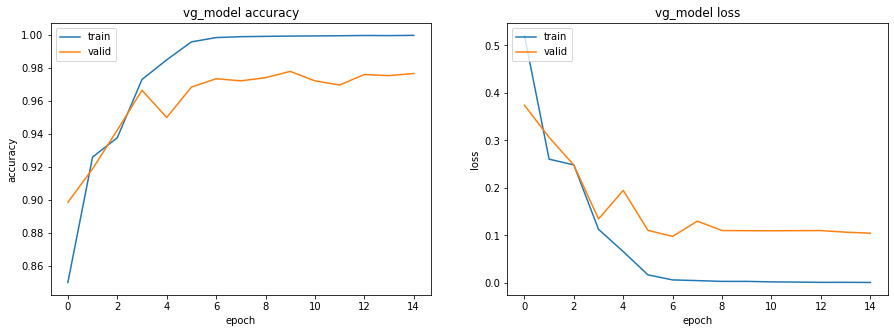

In [79]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(vg_model_hist.history['accuracy'])
ax[0].plot(vg_model_hist.history['val_accuracy'])
ax[0].set_title('vg_model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'], loc='upper left')


ax[1].plot(vg_model_hist.history['loss'])
ax[1].plot(vg_model_hist.history['val_loss'])
ax[1].set_title('vg_model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'], loc='upper left')
plt.show()

In [12]:
_, acc = vg_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 23s 584ms/step - loss: 0.1969 - accuracy: 0.9467
Valid Accuracy: 94.667


#### Let's train the model for a few more epoch with a lower learning rate and perphaps we can reach a higher accuracy rate.

In [85]:
vg_model.compile(Adam(1e-6),loss='categorical_crossentropy',metrics=['accuracy'])


callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

vg_model_hist = vg_model.fit(train_generator,
                            epochs=10,
                            validation_data=valid_generator,
                            callbacks=callback, verbose=1)

Epoch 1/10
719/719 [==============================] - 361s 501ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.1093 - val_accuracy: 0.9771 - lr: 1.0000e-06
Epoch 2/10
719/719 [==============================] - 340s 472ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1022 - val_accuracy: 0.9771 - lr: 1.0000e-06
Epoch 3/10
719/719 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991
Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
719/719 [==============================] - 344s 478ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.1166 - val_accuracy: 0.9752 - lr: 1.0000e-06
Epoch 4/10
719/719 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9993
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
719/719 [==============================] - 352s 489ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.1131 - val_accuracy: 0.9771 - lr: 5.0000e-07
Epoch 5/10
719/719

In [86]:
_, acc = vg_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 11s 454ms/step - loss: 0.0992 - accuracy: 0.9765
Valid Accuracy: 97.651


In [87]:
vg_model.save('vg_tuned_model')

INFO:tensorflow:Assets written to: vg_tuned_model\assets


In [5]:
vg_tuned_model = keras.models.load_model('C:/Users/izine/Desktop/GitHub/Springboard-Data-Science/Capstone 3/Notebooks/vg_tuned_model')

In [13]:
_, acc = vg_tuned_model.evaluate(test_generator, verbose=1)
print('Valid Accuracy: %.3f' % (acc * 100))

25/25 [==============================] - 11s 434ms/step - loss: 0.0957 - accuracy: 0.9759
Valid Accuracy: 97.587


In [ ]:
#Due to tensorflow workload this hogs up my dedicated GPU memory and even though a model completes execution it continues to hold
# the GPU memory hostage so doing this after sessions allows my GPU to free up.
from numba import cuda

cuda.select_device(0)
cuda.close()

### 1.6 Predictions <a id='1.6_Predictions'></a>

We will now predict onto some random images from the first batch of our test generator. 

In [17]:
vg_prediction = vg_tuned_model.predict(test_generator, verbose=1)

25/25 [==============================] - 11s 434ms/step


In [15]:
ef_prediction = ef_model.predict(test_generator, verbose=1)

25/25 [==============================] - 12s 433ms/step


In [157]:
species = test_generator.class_indices

In [158]:
species  = { species[k]:k for k in species}

Recall we preprocessed our images in order for our pre-trained model to easily digest the images, but due to that the images data when represented by matplot.lib plots are not identical to the original images and are vastly different for that reason I have used the function below provided by Sanchit Vijay to deprocess the image back to its original data values. 

In [189]:
#Thanks to user Sanchit Vijay from stackoverflow I was able to reverse the images back to original format since I had originally
#Pre-proccessed my images for vg16
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

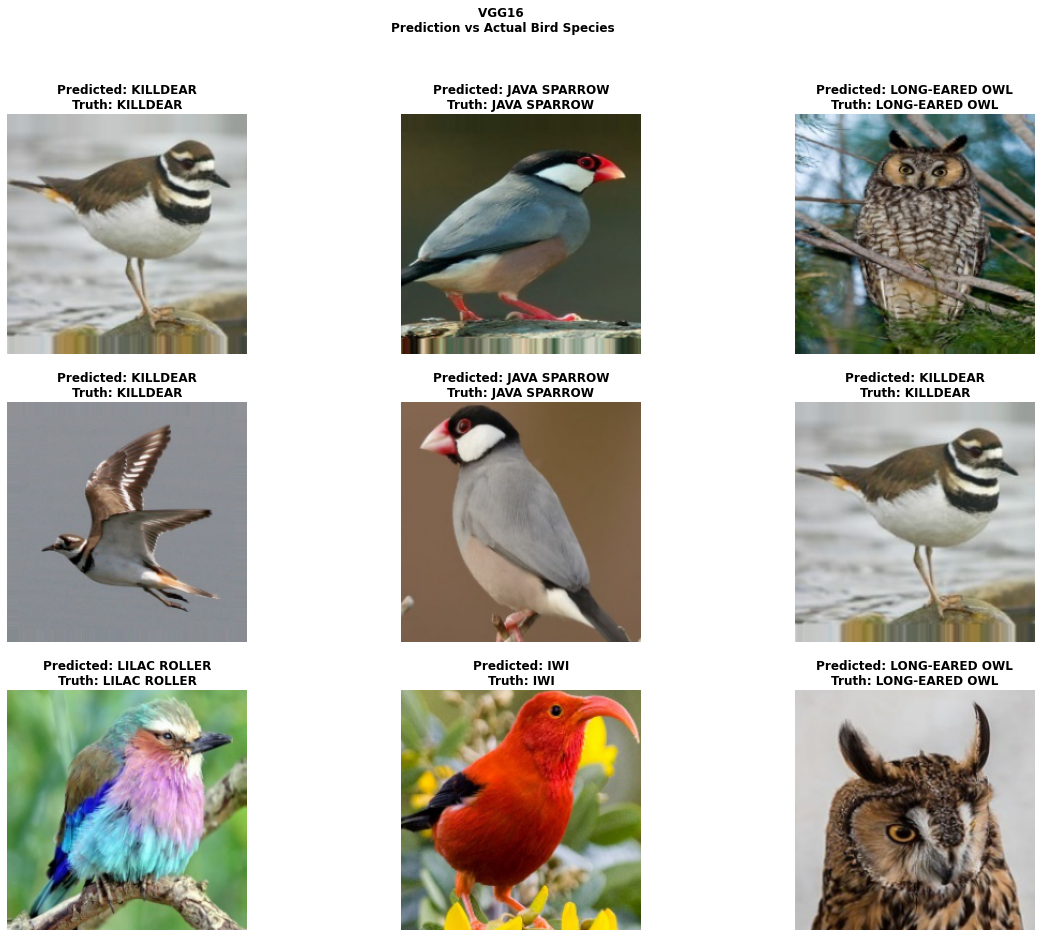

In [195]:
images, labels = test_generator.next()
predictions = vg_tuned_model.predict(images)
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(3, 3)

fig.suptitle("VGG16 \nPrediction vs Actual Bird Species", weight='bold')
for row in range(0,3):
    for col in range(0,3):
        img = random.randint(0, len(images)-1)
        image = images[img]
        prediction = species[np.argmax(predictions[img])]
        truth = species[np.argmax(labels[img])]
        ax = fig.add_subplot(gs[row,col])
        ax.axis('off')
        ax.imshow(deprocess_img(image))
        ax.set_title("Predicted: " + prediction  + "\nTruth: " + truth, fontdict={"fontweight": 500}, weight='bold')
        

I must say I ran these numerous times and there were many birds that look identical that I could barely tell apart yet they were of different species

#### Side note these predictions made via the EfficientNet model is from the previous iteration when I had acheived a 94% accuracy score, and is not the prediction of the recent redo, again due to constrain of time and resource I decided not to replicate the previous model since our VGG16 model has outperformed it.

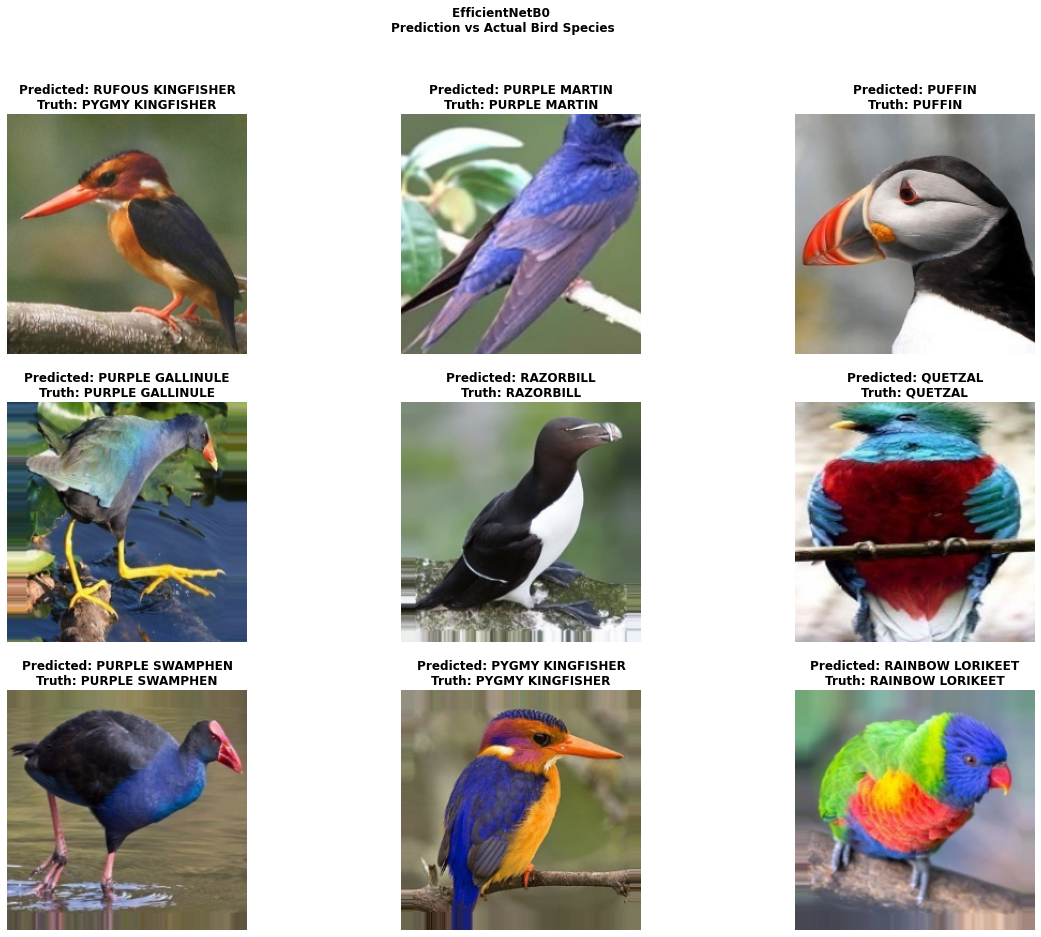

In [199]:
images, labels = test_generator.next()
predictions = ef_model.predict(images)
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(3, 3)

fig.suptitle("EfficientNetB0 \nPrediction vs Actual Bird Species", weight='bold')
for row in range(0,3):
    for col in range(0,3):
        img = random.randint(0, len(images)-1)
        image = images[img]
        prediction = species[np.argmax(predictions[img])]
        truth = species[np.argmax(labels[img])]
        ax = fig.add_subplot(gs[row,col])
        ax.axis('off')
        ax.imshow(deprocess_img(image))
        ax.set_title("Predicted: " + prediction  + "\nTruth: " + truth, fontdict={"fontweight": 500}, weight='bold')
        

## 1.7 Summary <a id='1.7_Sumarry'></a>

Working on this image classification problem has been a massive learning experience as it has taught me how to work with Keras API's and different libaries as well as diverting from your traditional tabular data. Ironically the easiest task on this project was working with the data, as it was the cleaniest data I have worked with unlike my prior tabular projects where data is dirty and difficult to operate on. Other quirks I had to tackle was just implementing different ways of loading and setting up the dataset for my models other than that it was a smooth transition from loading the data and implementing it into my models. 
    
The most challenging part of this project was fully understanding the complexities of a Neural Network and how to implement Convolutional blocks alongside maxpooling and etc. While most time was spent building a Keras model from scratch and fine-tuning that model, it was also the most rewarding. Initially working with pre-trained models seemed simple, but properly configuring them for your dataset is key, and tuning them is a even bigger factor. Through the tuning process I was able to learn and implement the freezing and unfreezing technique to squeeze even more performance of pre-trained models. 
    
I was quite surprised at the dataset as many of the bird species while different look very similar, for instantance to even a human eye the Pygmy Kingfisher looks identical to a Rufous Kingfisher, but the models did a great job of extracting key features to distinguish different species with similar looks and features.
    
This is only a stepping stone, as the world of classification of images is endless, while this project was a learning experience I believe there a lot more I can learn when it comes to classification and recognition of images. This dataset was very usable, I can only imagine how difficult it would've been if the dataset required a lot of rework to able to process into models. I believe projects working on object detection and facial recognition would an interesting challenge and I will continue what I've learned here into those problems. 
    
    

